In [1]:
import os
import numpy as np
import pandas as pd

import cv2
import sys
import gc

import matplotlib.pyplot as plt


IMG_HEIGHT = 180
IMG_WIDTH = 180

In [2]:
#  https://www.analyticsvidhya.com/blog/2021/08/beginners-guide-to-convolutional-neural-network-with-implementation-in-python/
# Upload libraries and Choose a CNN Architecture: 

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.models import load_model

from keras.backend import clear_session
# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session

## methods for accuracy check

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix # requires counts , integers , 1 or 0
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import ConfusionMatrixDisplay


from random import sample


In [3]:
def debug_photo( photo  ):
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 4
    for i in range(1, columns*rows +1):
        loc = np.random.randint(1, len(photo),1 )
        img= photo[loc[0]]  # 1 class pictures , sampled randomly
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap = "gray")
    plt.show()
    

In [4]:
### Specific to GreyScale
def preprocess_image( x, h=IMG_HEIGHT , w=IMG_WIDTH, pad_value=30, color_scheme=cv2.COLOR_BGR2GRAY, inter_method=cv2.INTER_CUBIC ):
    
        timage = cv2.cvtColor(x, color_scheme) 
        
        timage = cv2.copyMakeBorder(timage, pad_value, pad_value, pad_value, pad_value, 
                                           cv2.BORDER_CONSTANT, None, value=[255, 255, 255] ) 
        
        timage=cv2.resize(timage, (h, w), # make all pictures standard
                                 interpolation = inter_method)
        
        
        return timage
        

In [5]:
def accuracy_metrics(model ,  x_test , y_test , loop_count, sample_size ):

        for i in range(0,loop_count):

                loc = np.random.choice( x_test.shape[0], size = int( sample_size*x_test.shape[0]  ), replace=False, p=None)
                x_test_sample = x_test[loc]
                y_test_sample = y_test[loc]
                out = model.predict(x_test_sample)
                out_classes = ( out >= 0.7 ) + 0 # to whole numbers 

                ac_metrics = {
                    "accuracy": [accuracy_score( y_test_sample , out_classes )], 
                    "precision":[precision_score( y_test_sample , out_classes, zero_division=0) ], 
                    "recall":[recall_score( y_test_sample , out_classes )]
                             }

                out_table = pd.DataFrame(ac_metrics,  index=[i])

                if i==0:   
                    result = out_table
                else:
                    result = pd.concat([result, out_table])
                    
        return result  
    

In [40]:
#sys.modules[__name__].__dict__.clear()
#gc.collect()

In [6]:
## Upload train and test data of 1-st class
# del img_data_train_test

data_location = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"

img_data_train_test=[] # store pixels  of 0 class
img_data_train_test_classes=[] # store pixels of apples pictures


for dir1 in os.listdir(data_location): # loop through files in each folder
              
        image_path= os.path.join(data_location, dir1) # full path to file we need to upload

        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimentions
        
        image = preprocess_image(x = image, pad_value=0 )
                 
        img_data_train_test.append(image) # append each picture to single structure
        img_data_train_test_classes.append(1)    # assign class for picture
   

In [7]:
img_data_train_test[0].shape

(180, 180)

In [8]:
## check how size of file depends of image dimetions
sys.getsizeof(img_data_train_test) # 53080 for 250 * 250, no resize during import
                                   # same value for 200*200
                                   # same value for 400*400

41880

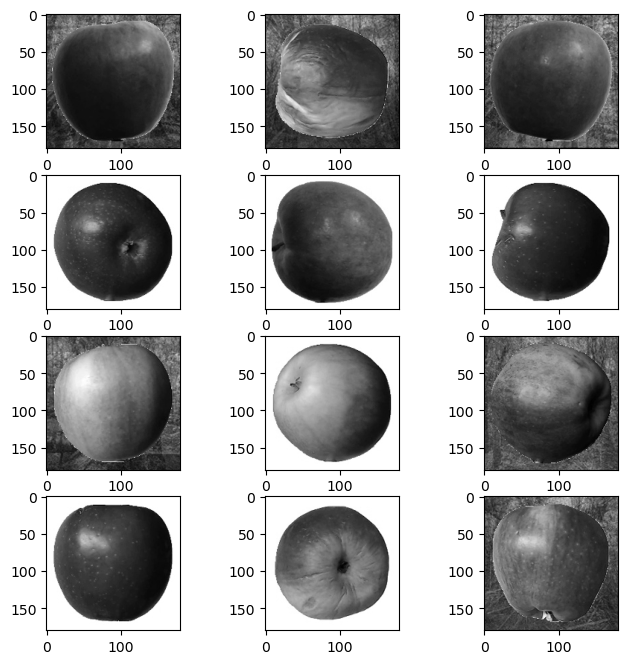

In [9]:
debug_photo( photo=img_data_train_test )    

In [7]:
## Upload train and test data of 0 class

data_location = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\3_Train_Test_Augmented_0_class"

for dir1 in os.listdir(data_location): # loop through files in each folder
              
        image_path= os.path.join(data_location, dir1) # full path to file we need to upload

        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimentions
        
        image = preprocess_image(x = image, pad_value=0 )
                 
        img_data_train_test.append(image) # append each picture to single structure
        img_data_train_test_classes.append(0)     
 

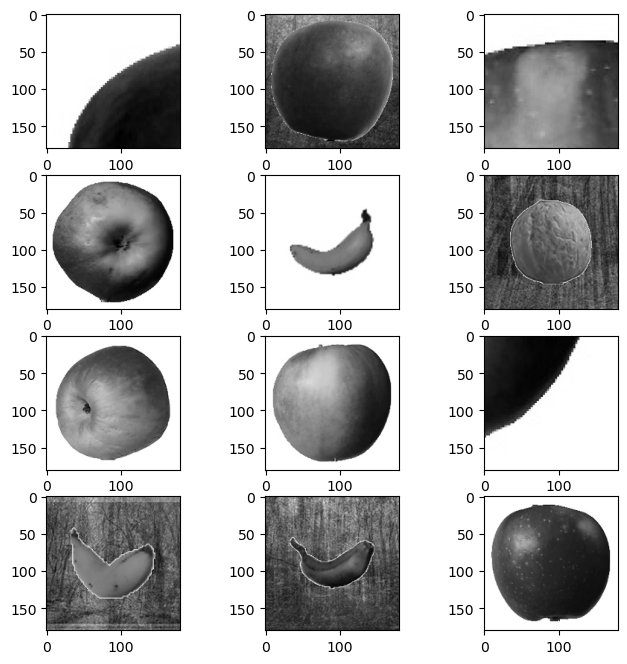

In [11]:
debug_photo( photo=img_data_train_test )    

In [8]:
### Upload last portion of 0 class non augmented photos

data_location = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\4_Train_Test_NON_Augmented_0_class"

for dir1 in os.listdir(data_location): # loop through files in each folder
              
        image_path= os.path.join(data_location, dir1) # full path to file we need to upload

        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimentions
        
        image = preprocess_image(x = image, pad_value=0 )
                  
        img_data_train_test.append(image) # append each picture to single structure
        img_data_train_test_classes.append(0)     

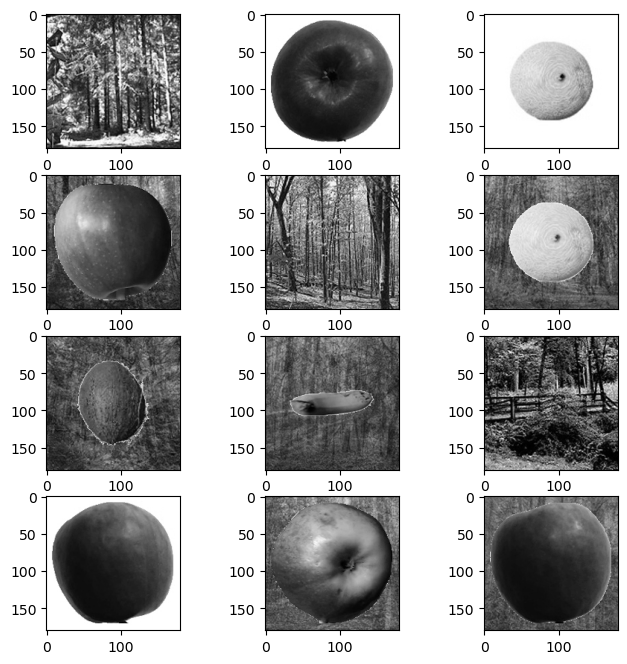

In [9]:
debug_photo( photo=img_data_train_test )    

In [10]:
# generate train and test datasets 
# sklearn and keras requre np.array class

x_train_test = np.array( img_data_train_test, dtype = "float16" )
y_train_test = np.array(img_data_train_test_classes ) # int32 by default

x_train_test[0].shape

# https://stackoverflow.com/questions/43440821/the-real-difference-between-float32-and-float64

In [12]:
del img_data_train_test , img_data_train_test_classes

In [13]:
# Normalize pixels values
    
x_train_test /= 255 

# https://medium.com/analytics-vidhya/a-tip-a-day-python-tip-8-why-should-we-normalize-image-pixel-values-or-divide-by-255-4608ac5cd26a#:~:text=The%20pixel%20values%20can%20range,range%20from%200%20to%201.
# https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/

In [14]:
#### how float type affects size
sys.getsizeof( x_train_test ) # for float16 , 7190625160, bytes, 7190 mega
                              # for float32 , 14381250160 ,  14381 mega, twice as much
# https://stackoverflow.com/questions/46613748/float16-vs-float32-for-convolutional-neural-networks    
# We can manipulate data type to avoid memory error

1157587344

In [15]:
[ x_train_test.shape ,y_train_test.shape ]

[(17864, 180, 180), (17864,)]

In [16]:
[ x_train_test.dtype , y_train_test.dtype ]

[dtype('float16'), dtype('int32')]

In [17]:
## we want class of interest to be more than 20% to avoid class imbalance
round( sum(y_train_test) / y_train_test.shape[0] ,3 )

0.279

In [18]:
##### Split data into train and test split
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

# for memory error 
# https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type

# with float32 I get 
# MemoryError: Unable to allocate 10.9 GiB for an array with shape (15564, 250, 250, 3) and data type float32

# with float16 I avoid memory error with train_test_split,
# but training time is beyond reasonable timeframe

#### train data  + remainder data ( validation and test )
x_train, x_rem, y_train, y_rem =  train_test_split( x_train_test ,  y_train_test , test_size = 0.35 , shuffle=True, stratify =  y_train_test)
  # dont confuse training and test size
    
#### remainder data split to validation and test
x_valid, x_test, y_valid, y_test = train_test_split(x_rem , y_rem , test_size=0.5,  shuffle=True, stratify =  y_rem)


In [131]:
# del  x_train_test , y_train_test, x_rem, y_rem, keep it for evaluation
gc.collect()

3314

In [20]:
# debug
print(x_train.shape), print(y_train.shape) # is the largest
print(x_valid.shape), print(y_valid.shape) # valid and test are the same
print(x_test.shape), print(y_test.shape)

(11611, 180, 180)
(11611,)
(3126, 180, 180)
(3126,)
(3127, 180, 180)
(3127,)


(None, None)

In [21]:
y_train.shape

(11611,)

In [22]:
 # debug, check class balance

[ sum(y_train) / y_train.shape[0] , sum(y_valid) / y_valid.shape[0]   , sum(y_test) / y_test.shape[0]    ] 


[0.27887348204289036, 0.27895073576455537, 0.2788615286216821]

In [239]:
# delete model if exists
try:
    del model
except:
    print("not generated")

not generated


In [240]:
# https://towardsdatascience.com/how-to-calculate-the-number-of-parameters-in-keras-models-710683dae0ca#:~:text=Model%20Summary&text=Each%20layer%20has%20an%20output,are%20trained%20for%20each%20layer.
# https://www.baeldung.com/cs/convolutional-layer-size

model = Sequential()

model.add( Conv2D( input_shape=(IMG_HEIGHT, IMG_WIDTH,1) , filters = 16 ,  padding="same" , kernel_size = (3,3) , activation="relu" ) ) # 16 *(3*3*3) + 16
model.add( MaxPool2D( pool_size=(2,2), strides=(2,2) ) )

model.add( Conv2D(  filters = 32 ,  padding="same" , kernel_size = (3,3) , activation="relu" ) ) # 16 *(3*3*3) + 16
model.add( MaxPool2D( pool_size=(2,2), strides=(2,2) ) )

model.add( Conv2D(  filters = 64 ,  padding="same" , kernel_size = (3,3) , activation="relu" ) ) # 16 *(3*3*3) + 16
model.add( MaxPool2D( pool_size=(2,2), strides=(2,2) ) )

model.add( Conv2D(  filters = 128 ,  padding="same" , kernel_size = (3,3) , activation="relu" ) ) # 16 *(3*3*3) + 16
model.add( MaxPool2D( pool_size=(2,2), strides=(2,2) ) )

model.add( Flatten() )

model.add( Dense(units=64, activation="relu") )
model.add(Dense(units=1, activation="sigmoid")) 

# param_number = output_channel_number * (input_channel_number * kernel_height * kernel_width + 1)


In [241]:
opt = Adam(learning_rate=0.001) # usually its 0.001

model.compile(optimizer=opt, 
             loss=binary_crossentropy, # prob of 1 class
             metrics=['accuracy'])


In [242]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 64)      

In [243]:
# https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc

history = model.fit(
            x_train, 
            y_train,
            batch_size=52, # 
            epochs=5,
            verbose=1,
            #validation_split=0.3
            validation_data = ( x_valid , y_valid )
)


Epoch 1/5
224/224 [==============================] - 127s 555ms/step - loss: 0.0568 - accuracy: 0.9775 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 2/5
224/224 [==============================] - 120s 536ms/step - loss: 5.3006e-04 - accuracy: 0.9999 - val_loss: 2.4515e-04 - val_accuracy: 1.0000
Epoch 3/5
224/224 [==============================] - 128s 573ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 4/5
224/224 [==============================] - 135s 605ms/step - loss: 0.0077 - accuracy: 0.9984 - val_loss: 0.0013 - val_accuracy: 0.9994
Epoch 5/5
224/224 [==============================] - 136s 608ms/step - loss: 1.4544e-05 - accuracy: 1.0000 - val_loss: 5.9997e-04 - val_accuracy: 0.9997


In [244]:
print( history.history.keys() )

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


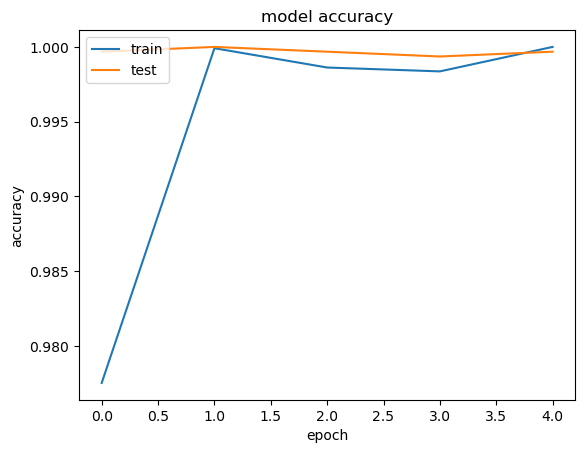

In [245]:
# summarize history for accuracy, usefull for multiple epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [246]:
model.save(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v0_cnn_binary.keras")
model_v0_cnn_binary = load_model(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v0_cnn_binary.keras")
        # model below is train with max of 64 filters which detects better than complications close to Vgg16
        # 1*16 , 1*32, 1*64 , flat , 128
 

In [247]:
clear_session()  

In [248]:
model_v0_cnn_binary.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 64)      

In [249]:
## Generate forecast with test data
out = model_v0_cnn_binary.predict( x_test ) 
np.unique( np.round(out,2) ) # debug , should be probabilities

# Note: increase of batch size and learning rate improved accuracy and increased recall

98/98 [==============================] - 14s 135ms/step


array([0.  , 0.01, 1.  ], dtype=float32)

In [250]:
out_classes = ( out >= 0.7 ) + 0 # to whole numbers 
np.unique( np.round(out_classes,2) )

array([0, 1])

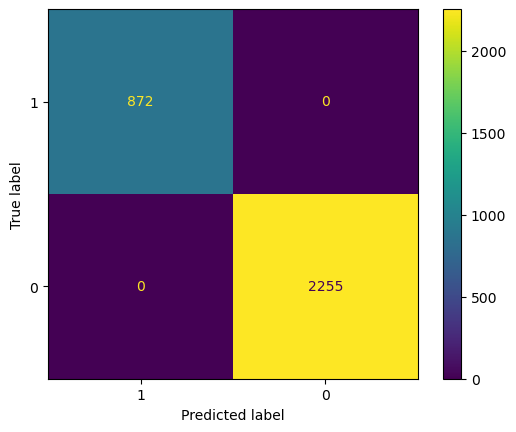

In [251]:
cm = confusion_matrix(y_test, out_classes, labels=np.array( [1,0] ))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.array( [1,0] ) )
disp.plot()
plt.show()

In [252]:
accuracy_metrics( model = model_v0_cnn_binary, x_test =  x_train_test , y_test = y_train_test , loop_count=3, sample_size=0.4)    

224/224 [==============================] - 32s 143ms/step


,accuracy,precision,recall
0,0.99986,1.0,0.999496
1,1.00000,1.0,1.000000
2,1.00000,1.0,1.000000


In [259]:
## Upload train and test data of 1-st class
# del img_data_train_test

folder_test = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class\Augmented_1"

img_data_test_array_0_class=[]
photos_list = os.listdir(folder_test)
loc = np.random.choice( len(photos_list) , size = 2000, replace=False, p=None)

for i in loc: # loop through folder in main directory
         
            image_path= os.path.join(folder_test, photos_list[i] ) # full path to file we need to upload
            image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
            
            image = preprocess_image(x = image, pad_value=0 )

            img_data_test_array_0_class.append(image) # append each picture to single structure


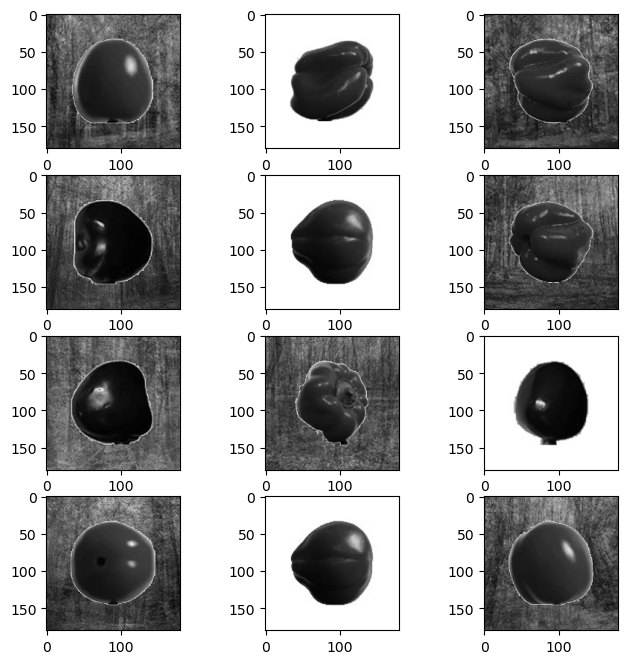

In [255]:
debug_photo( photo=img_data_test_array_0_class )       

In [260]:
img_data_test_array_0_class[0].shape

(180, 180)

In [261]:

x_test_buf_1 = np.array( img_data_test_array_0_class, dtype = "float16" )
# x_test_buf_1 = x_test_buf_1.reshape((x_test_buf_1.shape[0], 180*180)).astype('float16') # to 1d array

x_test_buf_1 /= 255

y_test_buf = np.ones(len(x_test_buf_1))

del img_data_test_array_0_class


In [262]:
[ x_test_buf_1.shape , y_test_buf.shape] 

[(2000, 180, 180), (2000,)]

In [263]:
## Generate forecast with test data

out = model_v0_cnn_binary.predict( x_test_buf_1 ) 


63/63 [==============================] - 9s 137ms/step


In [264]:
out_classes = ( out >= 0.7 ) + 0 # to whole numbers 
np.unique(out_classes)

array([0])

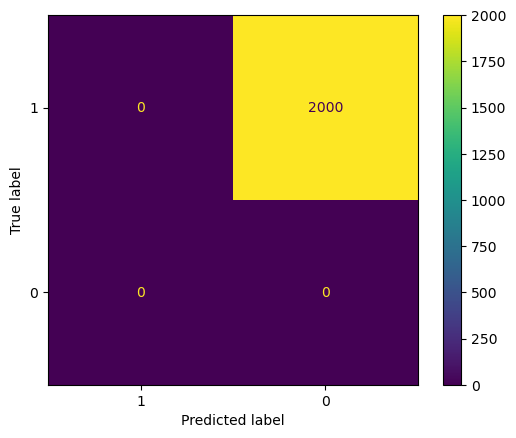

In [265]:
cm = confusion_matrix(y_test_buf, out_classes, labels=np.array( [1,0] ))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.array( [1,0] ) )
disp.plot()
plt.show()


In [266]:

folder_test = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\5_Test_FN_0_class\Augmented_2"

img_data_test_array_1_class_alt_form=[]
photos_list = os.listdir(folder_test)
loc = np.random.choice( len(photos_list) , size = 2000, replace=False, p=None)


for i in loc: # loop through folder in main directory
         
            image_path= os.path.join(folder_test, photos_list[i] ) # full path to file we need to upload
            image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
            
            image = preprocess_image(x = image, pad_value=0 )

            img_data_test_array_1_class_alt_form.append(image) # append each picture to single structure
 

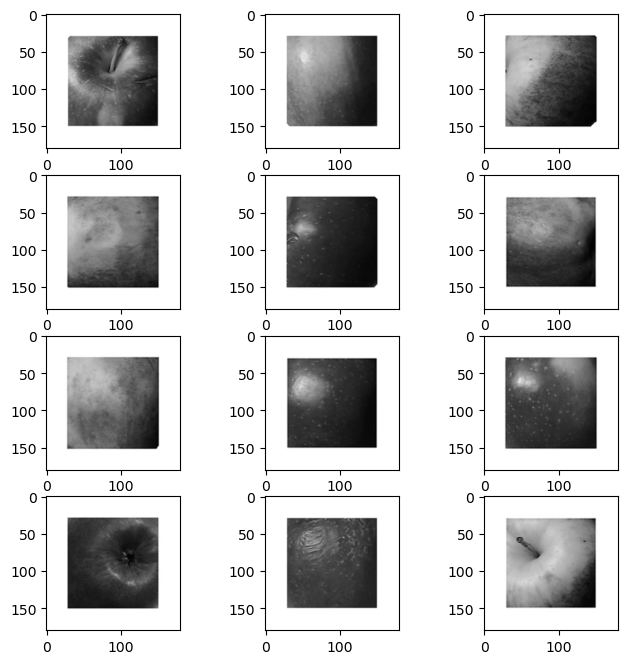

In [214]:
debug_photo( photo=img_data_test_array_1_class_alt_form )    

In [267]:

x_test_buf_3 = np.array( img_data_test_array_1_class_alt_form, dtype = "float16" )
#x_test_buf_3 = x_test_buf_3.reshape((x_test_buf_3.shape[0], 180*180)).astype('float16') # to 1d array

x_test_buf_3 /= 255

del img_data_test_array_1_class_alt_form


In [268]:
out = model_v0_cnn_binary.predict( x_test_buf_3 ) 
out_classes = ( out >= 0.7 ) + 0 # to whole numbers 

63/63 [==============================] - 8s 129ms/step


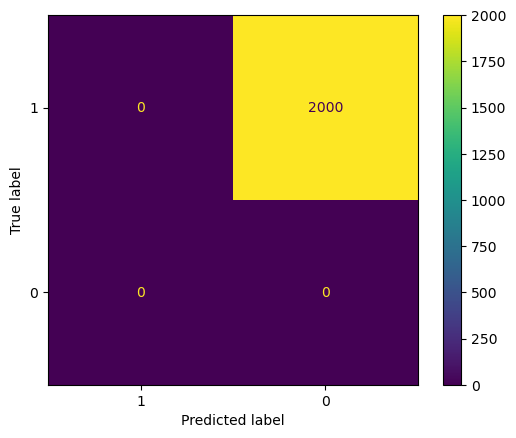

In [269]:
cm = confusion_matrix(y_test_buf, out_classes, labels=np.array( [1,0] ))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.array( [1,0] ) )
disp.plot()
plt.show()
